<h1 align="center"> <a href="https://engmrk.com/lenet-5-a-classic-cnn-architecture/"> Bayesian Lenet300-100 - Blundell's Weight Uncertainty Implementation</a></h1>
The architecture is as follows (for bayesian NN simply double the number of parameters):
<img src="architectures/lenet300_100.png" width=600 height=600 />

<p> For all the convolution NN architecture, we follow the following works. Unlike the dense models, here we have a closed form for KL. Additionally, instead of using scale-mixture prior, here we use Jeffrey's prior. </p>

We followed the implementation that was proposed by the following papers:
<ol>
<li> Blundell, Charles, et al. "Weight uncertainty in neural networks." arXiv preprint arXiv:1505.05424 (2015). 
</ol>
<p> <font color="red"> Need to explain the sampling technique for KL since it is different from the one proposed in the paper.</font> </p>

2020-05-18 16:41:06 

<font size="3" color="blue"><b> Exprimental Setting for Bayesian NN - Bayes-by-Backprop (BBB)</b></font>
    <li><b>Batch size</b>: 100</li>
    <li><b>KL scaling factor: </b>$\frac{1}{\#BatchesPerEpoch}$. This is <font color="red"> extremely important</font> since changing this will result in wide performance changes. In most cases, I found other Kl scaling factor to be detrimental to MNIST data. In the implementation this is indicated by the variable <i><font color="blue">standard1</font></i>.</li>
    <li><b>Retraining Methodology:</b> Unlike the CVPR paper, <b>we do not retrain from scratch</b>. We found that this method is mostly <b>detrimental to the performance </b> of all models (Both Bayesian and Non-bayesian). At each round, we simply re-use the previous weights, and train the model for a significantly less number of epoch. More precisely, We allot 10% of the training data as validation set and use an early stopping technique, to get the best parameters based on this validation set.</li>
    <li><b>Number of MCMC samples</b>: 5</li>
    <li><b>Optimization Algorithm</b>: Adam</li>
    <li><b>Number of NN instantiations</b>: 25. That is, when performing active learning, we create 25 instantiations of NN with dropout and estimate variation-ratio and entropy.</li>
    
    
<font size="3" color="blue"><b> Exprimental Setting for Dropout neural network (NN)</b></font>
<li><b>Batch Size</b>: 32</li>
<li> <b>Dropout Rate</b>: 0.5 (default in pytorch)</li>
<li><b>Retraining Methodology:</b> Unlike the CVPR paper, <b>we do not retrain from scratch</b>. We found that this method is mostly <b>detrimental to the performance </b> of all models (Both Bayesian and Non-bayesian). At each round, we simply re-use the previous weights, and train the model for a significantly less number of epoch. More precisely, We allot 10% of the training data as validation set and use an early stopping technique, to get the best parameters based on this validation set.</li>
<li><b>Optimization Algorithm</b>: Adam</li>
<li><b>Number of NN instantiations</b>: 25. That is, when performing active learning, we create 25 instantiations of NN with dropout and estimate variation-ratio and entropy.</li>
The legend used in the graph are as follows:
AL stands for <u>a</u>ctive <u>l</u>earning with dropout-based neural network, <font color="blue">AL-VR</font> stands for <b><u>a</u>ctive <u>l</u>earning using <u>v</u>ariation-<u>r</u>atio</b>, <font color="blue">AL-E</font> stands for <u>a</u>ctive <u>l</u>earning using <u>E</u>ntropy, RS stands for <u>r</u>andom <u>s</u>ampling, legends with the character <font color="blue">B</font> in front of them are the Bayesian couter parts of the variational-ratio and entropy active-learning algorithms respectively.

</p>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# import mpld3
from matplotlib import rc
import numpy as np
import pandas as pd
import os
import pdb
# supposed to help make graphs interactive, to zoom in, but does not work
# mpld3.enable_notebook()

In [19]:
#V2 Test Mode
plot_pth = 'McDropoutVsBayesianVariationRatio/'
class getMetric:

    def __init__(self, typ, pth, truncate_end, truncate_st, n_classes):
        self.files = [f for f in os.listdir(pth)]
        self.files = sorted(self.files, key=lambda x: int(x.split('round')[1].split('.csv')[0]))
        if typ == 'accuracy' and n_classes == 10:
            indx = 'accuracy'
        if typ == 'accuracy' and n_classes == 100:
            indx = 'accuracy'
        if typ == 'r2':
            indx = 'r2'
        # classification error
        if truncate_end == None:
            self.metric = [pd.read_csv(pth + f, index_col=0).loc[indx][0] for f in self.files][:40]
        else:
            if not truncate_st: truncate_st = 0
            self.metric = [pd.read_csv(pth + f, index_col=0).loc[indx][0] for f in self.files][truncate_st:truncate_end]

def PlotGraph(figure_nam,data_locs,labels,truncate_end=None,truncate_st=None, x_l=None,y_l=None,
              n_classes=10,isample=100, mini_window=False, metric='accuracy'):
    metric_list = [getMetric(metric,pth,truncate_end, truncate_st, n_classes).metric for pth in data_locs]
    rounds = range(len(metric_list[0]))
    if mini_window:
        mini_window_metric = [getMetric('accuracy',pth, 15, truncate_st, n_classes).metric for pth in data_locs]
        rounds_mini_window = range(len(mini_window_metric[0]))
    colors = ['#9B59B6','#76D7C4','#F5B041','#E74C3C','#2C3E50', '#3498DB']
    model_names = {'b_names':{'BBB':['BBB-VR','BBB-E','BBB-RS'],'Jeffrey':['BCN-VR', 'BCN-E']}}
    # create specific colors and markers
    markers, line_style = [], []
    for l in labels:
        if l in model_names['b_names']['BBB']:
            markers.append('^')
            line_style.append('--')
        elif l in model_names['b_names']['Jeffrey']:
            markers.append('X')
            line_style.append('--')
        else:
            markers.append('o')
            line_style.append('-')

    font = {'family': 'Serif',
            'weight': 'normal',
            'size': 14}
    rc('font', **font)
    if not figure_nam:
        figure_nam = 'my_fig.png'
    fig = plt.figure(num=1, figsize=(14, 7))
    ax = plt.axes()
    if mini_window:
        axins = ax.inset_axes([0.3, 0.1, 0.45, 0.4])
    for i,m in enumerate(metric_list):
        ax.plot(rounds, m, marker=markers[i], linestyle=line_style[i], color=colors[i], label=labels[i])
        if mini_window:
            axins.plot(rounds_mini_window, mini_window_metric[i], marker=markers[i], linestyle=line_style[i], color=colors[i], label=labels[i])
    if x_l:
        ax.set_xlim(x_l)
    if y_l:
        ax.set_ylim(y_l)

    ax.set_ylabel('Classification Accuracy', fontsize=18)
    ax.set_xlabel(r'# Samples ($\times ' + str(isample) + '$)', fontsize=18)
    ax.legend(loc=4, ncol=1, frameon=True)
    if mini_window: ax.indicate_inset_zoom(axins)
    plt.savefig(plot_pth+figure_nam, orientation='portrait', bbox_inches='tight', dpi=300)

In [2]:
# V1
plot_pth = 'McDropoutVsBayesianVariationRatio/'
class getMetric:

    def __init__(self, typ, pth, truncate_end, truncate_st, n_classes):
        self.files = [f for f in os.listdir(pth)]
        self.files = sorted(self.files, key=lambda x: int(x.split('round')[1].split('.csv')[0]))
        if typ == 'accuracy' and n_classes == 10:
            indx = 10
        if typ == 'accuracy' and n_classes == 100:
            indx = 100
        if typ == 'regression':
            indx = 100
        # classification error
        if truncate_end == None:
            self.metric = [pd.read_csv(pth + f).iloc[indx][1] for f in self.files][:40]
        else:
            if not truncate_st: truncate_st = 0
            self.metric = [pd.read_csv(pth + f).iloc[indx][1] for f in self.files][truncate_st:truncate_end]

def PlotGraph(figure_nam,data_locs,labels,truncate_end=None,truncate_st=None, x_l=None,y_l=None,
              n_classes=10,isample=100, mini_window=False):
    metric_list = [getMetric('accuracy',pth,truncate_end, truncate_st, n_classes).metric for pth in data_locs]
    rounds = range(len(metric_list[0]))
    if mini_window:
        mini_window_metric = [getMetric('accuracy',pth, 15, truncate_st, n_classes).metric for pth in data_locs]
        rounds_mini_window = range(len(mini_window_metric[0]))
    colors = ['#9B59B6','#76D7C4','#F5B041','#E74C3C','#2C3E50', '#3498DB']
    model_names = {'b_names':{'BBB':['BBB-VR','BBB-E','BBB-RS'],'Jeffrey':['BCN-VR', 'BCN-E']}}
    # create specific colors and markers
    markers, line_style = [], []
    for l in labels:
        if l in model_names['b_names']['BBB']:
            markers.append('^')
            line_style.append('--')
        elif l in model_names['b_names']['Jeffrey']:
            markers.append('X')
            line_style.append('--')
        else:
            markers.append('o')
            line_style.append('-')

    font = {'family': 'Serif',
            'weight': 'normal',
            'size': 14}
    rc('font', **font)
    if not figure_nam:
        figure_nam = 'my_fig.png'
    fig = plt.figure(num=1, figsize=(14, 7))
    ax = plt.axes()
    if mini_window:
        axins = ax.inset_axes([0.3, 0.1, 0.45, 0.4])
    for i,m in enumerate(metric_list):
        ax.plot(rounds, m, marker=markers[i], linestyle=line_style[i], color=colors[i], label=labels[i])
        if mini_window:
            axins.plot(rounds_mini_window, mini_window_metric[i], marker=markers[i], linestyle=line_style[i], color=colors[i], label=labels[i])
    if x_l:
        ax.set_xlim(x_l)
    if y_l:
        ax.set_ylim(y_l)

    ax.set_ylabel('Classification Accuracy', fontsize=18)
    ax.set_xlabel(r'# Samples ($\times ' + str(isample) + '$)', fontsize=18)
    ax.legend(loc=4, ncol=1, frameon=True)
    if mini_window: ax.indicate_inset_zoom(axins)
    plt.savefig(plot_pth+figure_nam, orientation='portrait', bbox_inches='tight', dpi=300)

<h2 align="center">MNIST data</h2>

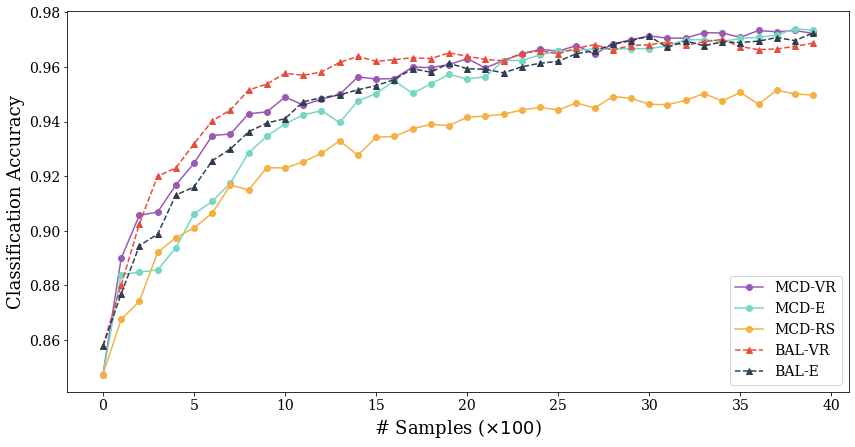

In [8]:
# 2020-05-03 19:07:02 500 initial samples and KL Scalar as standard1 (i.e., 1/m)
pth_1 = '../results_archive/McDropout/lenet300-100_mnist_isample500_e50_r40_ac1_optim-Adam_top-k100_b32_rtAfter40_variation-ratio/'
pth_2 = '../results_archive/McDropout/lenet300-100_mnist_isample500_e50_r40_ac1_optim-Adam_top-k100_b32_rtAfter40_entropy/'
pth_3 = '../results_archive/McDropout/lenet300-100_mnist_isample500_e50_r40_ac0_optim-Adam_top-k100_b32_rtAfter40/'
# bayesian results
pth_4 = '../results_archive/Blenet300-100_mnist_isample500_e40_r40_ac1_Klreg-standard1_b100_mcmc5_netType-blundelloptim-Adam_variation-ratio_rtAfter40/'
pth_5 = '../results_archive/Blenet300-100_mnist_isample500_e40_r40_ac1_Klreg-standard1_b100_mcmc5_netType-blundelloptim-Adam_entropy_rtAfter40/'
locs = [pth_1, pth_2, pth_3, pth_4,pth_5]
labels = ['MCD-VR','MCD-E','MCD-RS','BAL-VR','BAL-E']
f_name = 'fig_a'
PlotGraph(f_name,locs,labels)

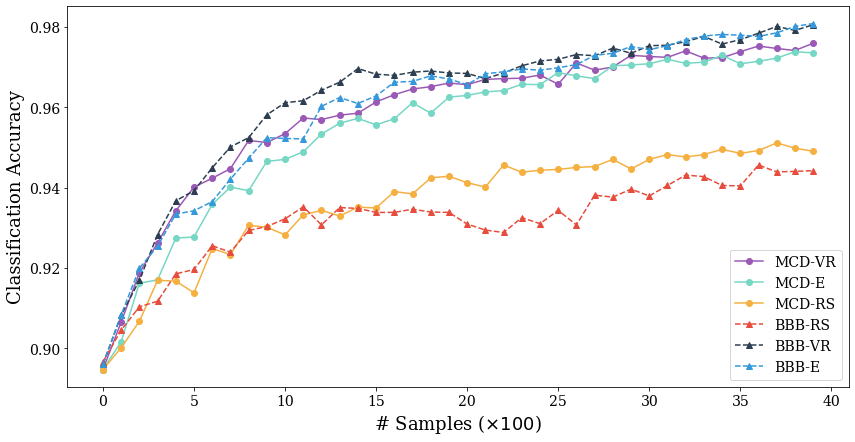

In [10]:
# 1000 initial samples
pth_1 = '../results_archive/McDropout/lenet300-100_mnist_isample1000_e50_r40_ac1_optim-Adam_top-k100_b32_rtAfter40_variation-ratio/'
pth_2 = '../results_archive/McDropout/lenet300-100_mnist_isample1000_e50_r40_ac1_optim-Adam_top-k100_b32_rtAfter40_entropy/'
pth_3 = '../results_archive/McDropout/lenet300-100_mnist_isample1000_e50_r40_ac0_optim-Adam_top-k100_b32_rtAfter40/'
# bayesian results
pth_4 = '../results_archive/Blenet300-100_mnist_isample1000_e50_r41_ac0_Klreg-standard1_b100_topK-100_mcmc5_netType-blundelloptim-Adamvariation-ratio_rtAfter100/'
pth_5 = '../results_archive/Blenet300-100_mnist_isample1000_e40_r40_ac1_Klreg-standard1_b100_mcmc5_netType-blundelloptim-Adam_variation-ratio_rtAfter40/'
pth_6 = '../results_archive/Blenet300-100_mnist_isample1000_e40_r40_ac1_Klreg-standard1_b100_mcmc5_netType-blundelloptim-Adam_entropy_rtAfter40/'
locs = [pth_1, pth_2, pth_3, pth_4,pth_5, pth_6]
labels = ['MCD-VR','MCD-E','MCD-RS', 'BBB-RS', 'BBB-VR','BBB-E']
f_name = 'fig_b'
PlotGraph(f_name,locs,labels, truncate_end=40, isample=100)

<b> Comparing Bayes-by-backprop (BBB) Vs Jeffreys </b>
We can see the performance of BBB and Jeffrey's are quite same. Except for one major difference. In Jeffry's the entropy measure tends to perform better.

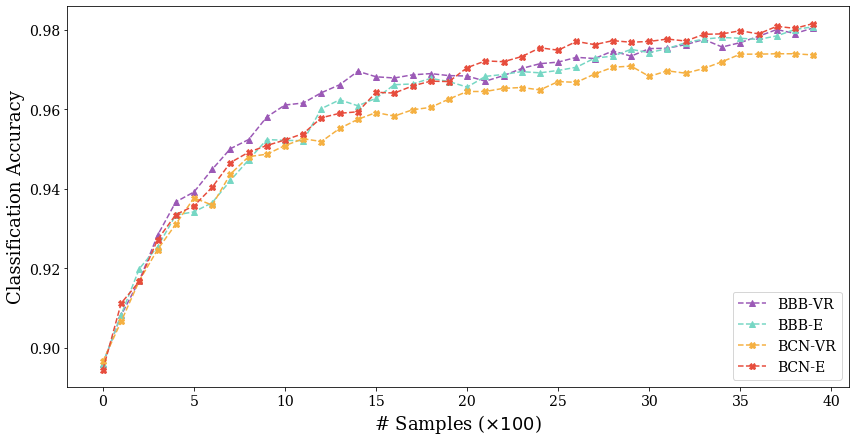

In [11]:
# 2020-05-20 23:26:01  1000 initial samples
pth_1 = '../results_archive/Blenet300-100_mnist_isample1000_e40_r40_ac1_Klreg-standard1_b100_mcmc5_netType-blundelloptim-Adam_variation-ratio_rtAfter40/'
pth_2 = '../results_archive/Blenet300-100_mnist_isample1000_e40_r40_ac1_Klreg-standard1_b100_mcmc5_netType-blundelloptim-Adam_entropy_rtAfter40/'
pth_3 = '../results_archive/Blenet300-100_mnist_isample1000_e50_r71_ac1_Klreg-standard1_b100_topK-85_mcmc5_netType-blundelloptim-Adam_entropy_rtAfter100/'
pth_4 = '../results_archive/Blenet300-100_mnist_isample1000_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_entropy_rtAfter100/'

locs = [pth_1, pth_2, pth_3, pth_4]
labels = ['BBB-VR','BBB-E','BCN-VR','BCN-E']
f_name = 'fig_c'
PlotGraph(f_name,locs,labels, isample=100)

<b> Sparse Training</b> We wanted to see the effect of NN for active learning when NN are trained with very less seed-sample. It is obvious that in such cases, the NN might not learn much and the AL decision could mostly be misleading. In such scenarios, we wanted to see how NN can recover from such scenario.
When starting with a seed set of just 10 the neural network is very weakly trained. Therefore, the active learning decisions made by the NN are erroneous. In the following graph illustrates this outcome. Here, one can see that just by using random sampling, we are able to improve the accuracy during the initial phase. That being said, it is interesting to see that bayesian NN out-perform  frequentist NN in certain scenarios. We found that BJAL-VR significantly outperforms the rest for the first 8-10 rounds. However, in reality this performance gain is purely due to chance (need a better explanation). BJAL-E on the other hand, suffers in performance initially, but outperforms all other models after around 15 rounds. This illustrates the robustness of Bayesian NN in active learning setting.
AL-E trails behind all other techniques and never gains any major improvement. <b> This effect is more profound for more challenging datasets such as Fashion MNIST (see upcoming section)</b>

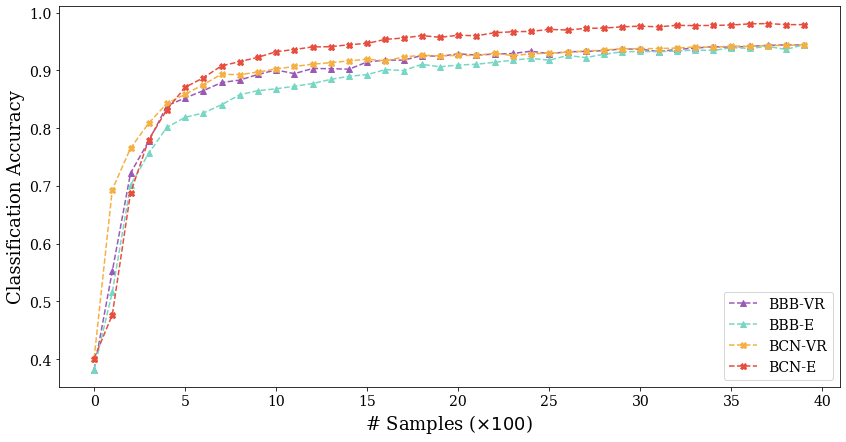

In [12]:
# 10 initial samples
pth_1 = '../results_archive/McDropout/lenet300-100_mnist_isample10_e50_r41_ac1_optim-Adam_top-k100_b32_rtAfter100_variation-ratio/'
pth_2 = '../results_archive/McDropout/lenet300-100_mnist_isample10_e50_r41_ac1_optim-Adam_top-k100_b32_rtAfter100_entropy/'
pth_3 = '../results_archive/Blenet300-100_mnist_isample10_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_variation-ratio_rtAfter100/'
pth_4 = '../results_archive/Blenet300-100_mnist_isample10_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_entropy_rtAfter100/'
locs = [pth_1, pth_2, pth_3, pth_4]
labels = ['BBB-VR','BBB-E','BCN-VR','BCN-E']
f_name = 'fig_d'
PlotGraph(f_name,locs,labels, isample=100, truncate_end=40)

2020-05-01 15:41:26 
<h2 align="center">Fashion MNIST data</h2>
All setting are similar to that of MNIST data, except for the number of McMc samples. Here we increase 

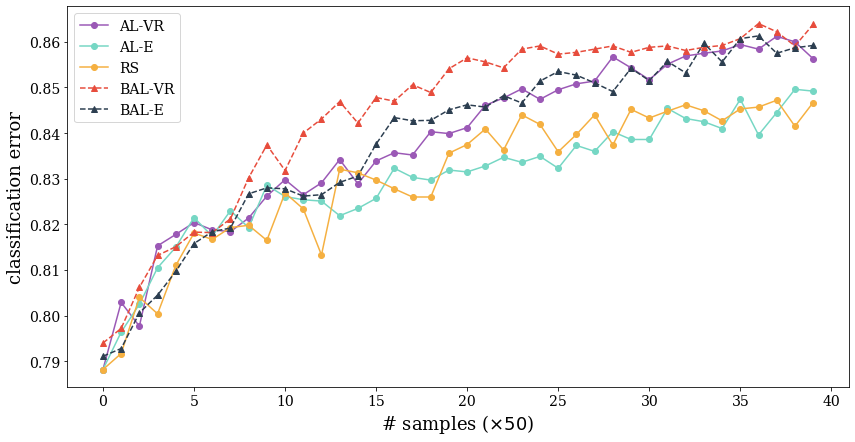

In [16]:
# 2020-05-03 19:07:02 500 initial samples and KL Scalar as standard1 (i.e., 1/m)
pth_1 = '../results_archive/McDropout/lenet300-100_fmnist_isample500_e50_r40_ac1_optim-Adam_top-k100_b32_rtAfter40_variation-ratio/'
pth_2 = '../results_archive/McDropout/lenet300-100_fmnist_isample500_e50_r40_ac1_optim-Adam_top-k100_b32_rtAfter40_entropy/'
pth_3 = '../results_archive/McDropout/lenet300-100_fmnist_isample500_e50_r40_ac0_optim-Adam_top-k100_b32_rtAfter40/'
# bayesian results
pth_4 = '../results_archive/Blenet300-100_fmnist_isample500_e40_r40_ac1_Klreg-standard1_b100_mcmc10_netType-blundelloptim-Adam_variation-ratio_rtAfter40/'
pth_5 = '../results_archive/FBlenet300-100_fmnist_isample500_e40_r40_ac1_Klreg-standard2_b100_mcmc20_netType-blundelloptim-Adam_entropy_rtAfter40/'
locs = [pth_1, pth_2, pth_3, pth_4,pth_5]
labels = ['AL-VR','AL-E','RS','BAL-VR','BAL-E']
f_name = 'fig_e'
PlotGraph(f_name,locs,labels)

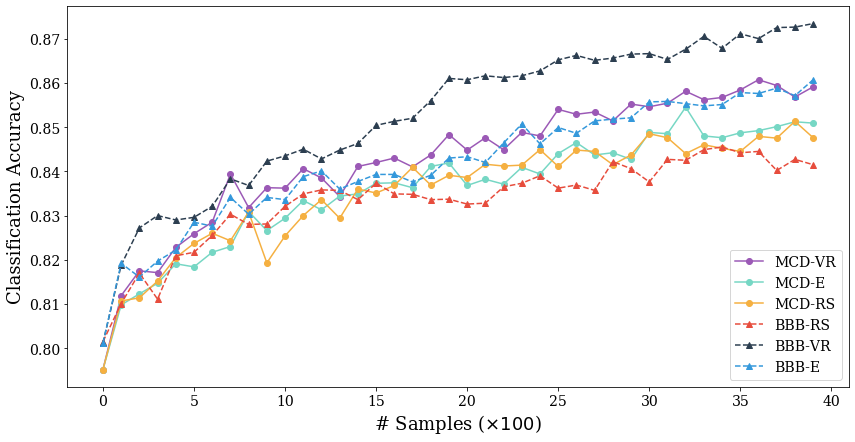

In [13]:
# 1000 initial samples
pth_1 = '../results_archive/McDropout/lenet300-100_fmnist_isample1000_e50_r40_ac1_optim-Adam_top-k100_b32_rtAfter40_variation-ratio/'
pth_2 = '../results_archive/McDropout/lenet300-100_fmnist_isample1000_e50_r40_ac1_optim-Adam_top-k100_b32_rtAfter40_entropy/'
pth_3 = '../results_archive/McDropout/lenet300-100_fmnist_isample1000_e50_r40_ac0_optim-Adam_top-k100_b32_rtAfter40/'
# bayesian results
pth_4 = '../results_archive/Blenet300-100_fmnist_isample1000_e50_r41_ac0_Klreg-standard1_b100_topK-100_mcmc5_netType-blundelloptim-Adamvariation-ratio_rtAfter100/'
pth_5 = '../results_archive/Blenet300-100_fmnist_isample1000_e40_r40_ac1_Klreg-standard1_b100_mcmc5_netType-blundelloptim-Adam_variation-ratio_rtAfter40/'
pth_6 = '../results_archive/Blenet300-100_fmnist_isample1000_e40_r40_ac1_Klreg-standard1_b100_mcmc5_netType-blundelloptim-Adam_entropy_rtAfter40/'
locs = [pth_1, pth_2, pth_3, pth_4,pth_5, pth_6]
labels = ['MCD-VR','MCD-E','MCD-RS','BBB-RS', 'BBB-VR','BBB-E']
f_name = 'fig_f'
PlotGraph(f_name,locs,labels,isample=100)

<b> Comparing Bayes-by-backprop (BBB) Vs Jeffreys </b>
We can see the performance of BBB and Jeffrey's are quite same. Except for one major difference. 
2020-07-13 13:13:39 - Updated the results of Jeffrey's. Earlier there was a major mistake in the active learning part of Jeffrey's. I found that basically, we were not sampling during inference! 
Now the results are consistent, Variation-ratio definitely outperforms entropy

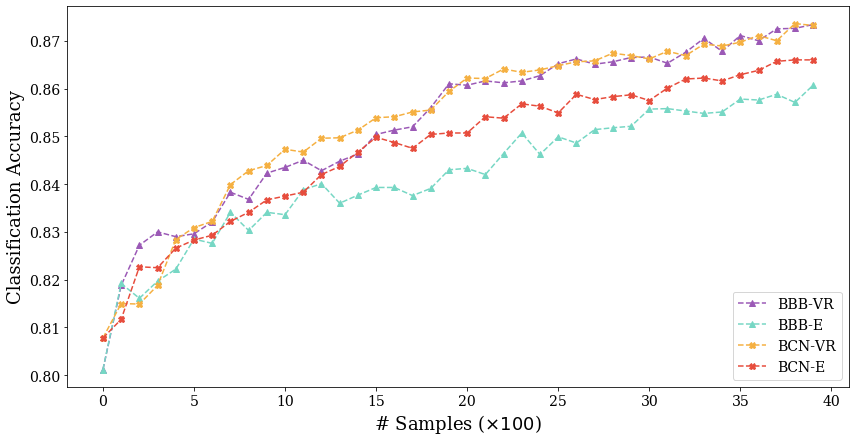

In [4]:
# 2020-07-13 13:11:49  1000 initial samples
pth_1 = '../results_archive/Blenet300-100_fmnist_isample1000_e40_r40_ac1_Klreg-standard1_b100_mcmc5_netType-blundelloptim-Adam_variation-ratio_rtAfter40/'
pth_2 = '../results_archive/Blenet300-100_fmnist_isample1000_e40_r40_ac1_Klreg-standard1_b100_mcmc5_netType-blundelloptim-Adam_entropy_rtAfter40/'
pth_3 = '../results/Blenet300-100_fmnist_isample1000_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
pth_4 = '../results/Blenet300-100_fmnist_isample1000_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_entropy_rtAfter0/'
locs = [pth_1, pth_2, pth_3, pth_4]
labels = ['BBB-VR','BBB-E','BCN-VR','BCN-E']
f_name = 'fig_g'
PlotGraph(f_name,locs,labels,isample=100)

<b> Sparse Training</b> We wanted to see the effect of NN for active learning when NN are trained with very less seed-sample. It is obvious that in such cases, the NN might not learn much and the AL decision could mostly be misleading. In such scenarios, we wanted to see how NN can recover from such scenario.
When starting with a seed set of just 10 the neural network is very weakly trained. Therefore, the active learning decisions made by the NN are erroneous. In the following graph illustrates this outcome. Here, one can see that just by using random sampling, we are able to improve the accuracy during the initial phase. That being said, it is interesting to see that bayesian NN out-perform  frequentist NN in certain scenarios. We found that BJAL-VR significantly outperforms the rest for the first 8-10 rounds. However, in reality this performance gain is purely due to chance (need a better explanation). BJAL-E on the other hand, suffers in performance initially, but outperforms all other models after around 15 rounds. This illustrates the robustness of Bayesian NN in active learning setting.
AL-E trails behind all other techniques and never gains any major improvement.

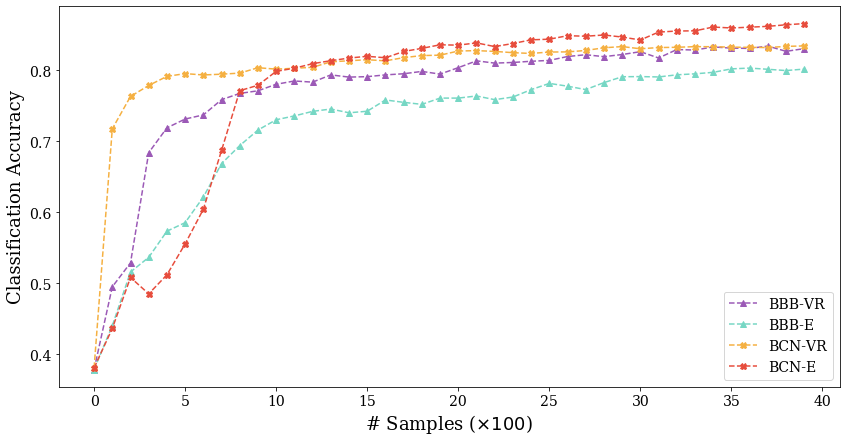

In [15]:
# 10 initial samples
pth_1 = '../results_archive/McDropout/lenet300-100_fmnist_isample10_e50_r41_ac1_optim-Adam_top-k100_b32_rtAfter100_variation-ratio/'
pth_2 = '../results_archive/McDropout/lenet300-100_fmnist_isample10_e50_r41_ac1_optim-Adam_top-k100_b32_rtAfter100_entropy/'
# pth_3 = '../results_archive/McDropout/lenet300-100_fmnist_isample10_e50_r41_ac0_optim-Adam_top-k100_b32_rtAfter100/'
# bayesian results
pth_4 = '../results_archive/Blenet300-100_fmnist_isample10_e50_r71_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_variation-ratio_rtAfter100/'
pth_5 = '../results_archive/Blenet300-100_fmnist_isample10_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_entropy_rtAfter100/'
locs = [pth_1, pth_2, pth_4, pth_5]
labels = ['BBB-VR','BBB-E','BCN-VR','BCN-E']
f_name = 'fig_h'
PlotGraph(f_name,locs,labels, truncate_end=40, isample=100)

2020-05-18 16:30:56 
<h1 align="center"> <a href="https://engmrk.com/lenet-5-a-classic-cnn-architecture/"> Bayesian Lenet 5 - Jeffrey's Prior </a></h1>
The architecture is as follows (for bayesian NN simply double the number of parameters):
<img src="architectures/lenet5_architecture.png" width=600 height=600 />

<p> For all the convolution NN architecture, we follow the following works. Unlike the dense models, here we have a closed form for KL. Additionally, instead of using scale-mixture prior, here we use Jeffrey's prior. </p>

We followed the implementation that was proposed by the following papers:
<ol>
<li> Kingma, Diederik P., Tim Salimans, and Max Welling. "Variational dropout and the local reparameterization trick." NIPS (2015). </li>
<li> Molchanov, Dmitry, Arsenii Ashukha, and Dmitry Vetrov. "Variational Dropout Sparsifies Deep Neural Networks." ICML (2017). </li>
<li> Louizos, Christos, Karen Ullrich, and Max Welling. "Bayesian Compression for Deep Learning." NIPS (2017).</li>
</ol>
<p> The KL divergence was implemented according to [3] Eq.(8), while the approximation of KL was performed based on [2] Eq.(14)</p>

2020-05-18 16:41:06 

<font size="3" color="blue"><b> Exprimental Setting for Bayesian NN </b></font>
    <li><b>Batch size</b>: 100</li>
    <li><b>KL scaling factor: </b>$\frac{1}{\#SamplesPerRound}$. This is according to [3]</li>
    <li><b>Retraining Methodology:</b> Unlike the CVPR paper, <b>we do not retrain from scratch</b>. We found that this method is mostly <b>detrimental to the performance </b> of all models (Both Bayesian and Non-bayesian). At each round, we simply re-use the previous weights, and train the model for a significantly less number of epoch. More precisely, We allot 10% of the training data as validation set and use an early stopping technique, to get the best parameters based on this validation set.</li>
    <li><b>Number of MCMC samples</b>: 1 <b>Note:</b>Since we have a closed form solution, we don't do MCMC to approximate KL. This significantly speeds up the execution time.</li>
    <li><b>Optimization Algorithm</b>: Adam</li>
    <li><b>Number of NN instantiations</b>: 25. That is, when performing active learning, we create 25 instantiations of NN with dropout and estimate variation-ratio and entropy.</li>
    
    
<font size="3" color="blue"><b> Exprimental Setting for Dropout neural network (NN)</b></font>
<li><b>Batch Size</b>: 32</li>
<li> <b>Dropout Rate</b>: 0.5 for the last 3 dense layers and 0.25 for the convolution layers</li>
<li><b>Retraining Methodology:</b> Unlike the CVPR paper, <b>we do not retrain from scratch</b>. We found that this method is mostly <b>detrimental to the performance </b> of all models (Both Bayesian and Non-bayesian). At each round, we simply re-use the previous weights, and train the model for a significantly less number of epoch. More precisely, We allot 10% of the training data as validation set and use an early stopping technique, to get the best parameters based on this validation set.</li>
<li><b>Optimization Algorithm</b>: Adam</li>
<li><b>Number of NN instantiations</b>: 25. That is, when performing active learning, we create 25 instantiations of NN with dropout and estimate variation-ratio and entropy.</li>
The legend used in the graph are as follows:
AL stands for <u>a</u>ctive <u>l</u>earning with dropout-based neural network, <font color="blue">AL-VR</font> stands for <b><u>a</u>ctive <u>l</u>earning using <u>v</u>ariation-<u>r</u>atio</b>, <font color="blue">AL-E</font> stands for <u>a</u>ctive <u>l</u>earning using <u>E</u>ntropy, RS stands for <u>r</u>andom <u>s</u>ampling, legends with the character <font color="blue">B</font> in front of them are the Bayesian couter parts of the variational-ratio and entropy active-learning algorithms respectively.

</p>

<h4 align="center">Fashion MNIST data</h4>

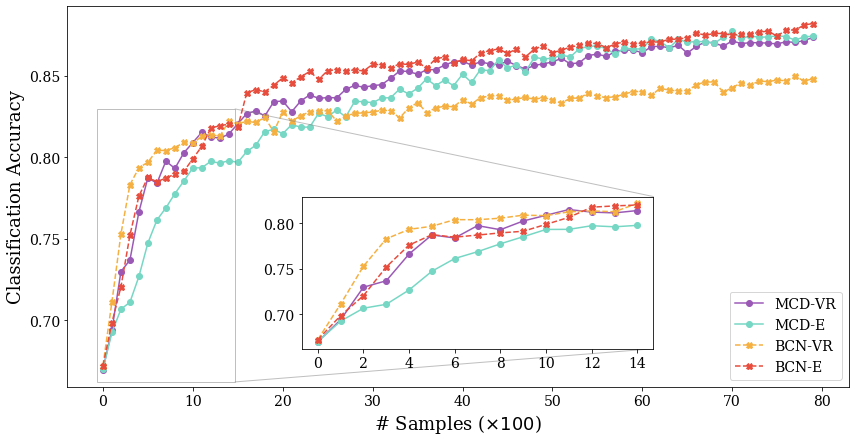

In [16]:
# with 50 samples at start 2020-05-25 18:43:21 
pth_1 = '../results_archive/McDropout/lenet5_fmnist_isample50_e50_r81_ac1_optim-Adam_top-k100_b32_rtAfter100_variation-ratio/'
pth_2 = '../results_archive/McDropout/lenet5_fmnist_isample50_e50_r81_ac1_optim-Adam_top-k100_b32_rtAfter100_entropy/'
pth_3 = '../results_archive/lenet5_fmnist_isample50_e50_r81_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_variation-ratio_rtAfter100/'
pth_4 = '../results_archive/lenet5_fmnist_isample50_e50_r81_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_entropy_rtAfter100/'
locs = [pth_1, pth_2, pth_3, pth_4]
labels = ['MCD-VR','MCD-E','BCN-VR','BCN-E']
f_name = 'fig_i'
PlotGraph(f_name,locs,labels, truncate_end=80, isample=100, mini_window=True)

<h2 align="center"> Alexnet Using Fully Bayesian NN </h2>
<p>
<font size="3">Model Type:<b>Alexnet</b> program file name <b>TrainSimpleDropout_v2_beta.py</b></font> The best accuracy for a full Alexnet architecture is ~ 78.5%. Using a fully-bayesian NN and active learning we are able to achieve <b> ~ 77.5%, with < 40% of the data </b>.

The architecture is as follows (for bayesian NN simply double the number of parameters):
<img src="architectures/Alexnet_architecture.png" width=600 height=600 />


<font size="3"><b> Exprimental Setting for Bayesian NN</b></font>
    <li> Fully Bayesian NN: We found that as we increase the number of convolution layers, the mixture between a frequentist NN and a bayesian NN does not play well. We start to see severe performance losses, especially in the active learning setting, where we keep appending data samples in each round. Therefore, we used an end-to-end bayesian NN. <b>Note: Unlike the MCMC version of BNN used in other experiments, here I used a closed form version </b></li>
    <li><b>KL scaling factor: </b>$\frac{1}{\# Number of data samples in a round}$. This is <font color="red"> extremely important</font> since changing this will result in wide performance changes. In most cases, I found other Kl scaling factor to be detrimental to MNIST data. In the implementation this is indicated by the variable <i><font color="blue">standard2</font></i>.</li>
    <li><b>Training batch size</b>: 100</li>
    <li><b>Training/Testing Method:</b> Unlike the CVPR paper, <b>we do not retrain from scratch</b>. We found that this method is mostly <b>detrimental to the performance </b> of all models (Both Bayesian and Non-bayesian). At each round, we simply re-use the previous weights, and train the model for a significantly less number of epoch. More precisely, We allot 5% of the training data as validation set and use an early stopping technique, to get the best parameters based on this validation set.</li>
    <li><b>Number of MCMC samples</b>: 1 (due to closed form KL, we just need 1 sample)</li>
    <li><b>Number of NN instantiations</b>: 15. That is, when performing active learning, we create 15 instantiations of NN with dropout and estimate variation-ratio and entropy.</li>
    <li><b>Optimization Algorithm</b>: SGD. lr= 0.001, momentum=0.9<b> Note: I found that using Adam optimization leads to sub-optimal results. Specifically, I found that after adding new data samples in each round, the model gets trapped in some local optimum and struggles to move forward. This however does not seem to be a problem when using the entire dataset.</b></li>

<font size="3"><b> Exprimental Setting for Dropout neural network (NN)</b></font>
<li>Batch Size: 32</li>
<li> <b>Dropout Rate</b>: 0.5 for the last 3 dense layers and 0.25 for the convolution layers</li>
<li> <b># Batchs Per-Round</b>:In each round, we add 500 samples (when compared to just 100 in MNIST and FMNIST)</li>
<li><b>Training Methodology</b>:We retrain the model from scratch after <b> each round </b></li>
<li><b>Optimization Algorithm</b>: SGD. lr= 0.001, momentum=0.9<b> Note: I found that using Adam optimization leads to sub-optimal results. Specifically, I found that after adding new data samples in each round, the model gets trapped in some local optimum and struggles to move forward. This however does not seem to be a problem when using the entire dataset.</b></li>
<li><b>Number of NN instantiations</b>: 15. That is, when performing active learning, we create 15 instantiations of NN with dropout and estimate variation-ratio and entropy.</li>
<li>At each round we randomly allocate 10% of the training data as validation. We adopt an early stopping criteria, where we choose the parameters that result in the best accuracy for this validation set.</li>
The legend used in the graph are as follows:
AL stands for <u>a</u>ctive <u>l</u>earning with dropout-based neural network, <font color="blue">AL-VR</font> stands for <b><u>a</u>ctive <u>l</u>earning using <u>v</u>ariation-<u>r</u>atio</b>, <font color="blue">AL-E</font> stands for <u>a</u>ctive <u>l</u>earning using <u>E</u>ntropy, RS stands for <u>r</u>andom <u>s</u>ampling, legends with the character <font color="blue">B</font> in front of them are the Bayesian couter parts of the variational-ratio and entropy active-learning algorithms respectively. <font color="blue">F</font> in front of them stands for Fully Bayesian (i.e., end-to-end) architectures.

All the results were obtained with an ensemble 15 instantiations of NN. The graphs here are the average prediction accuracies. 
</p>

<h4 align="center"> Fmnist Dataset </h4>

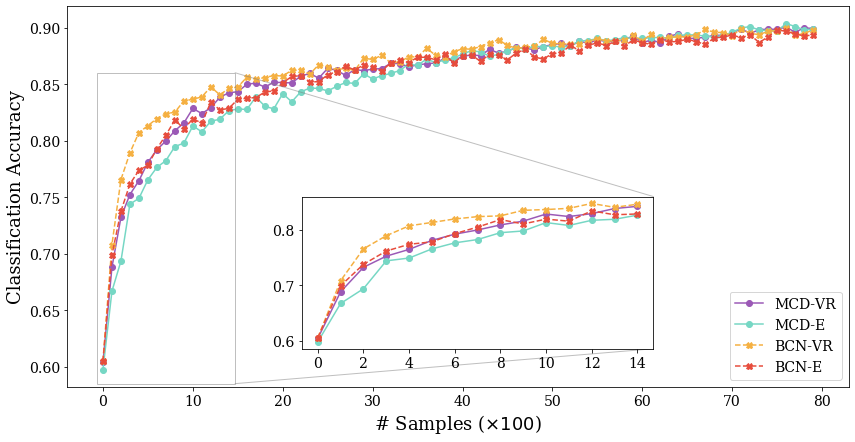

In [18]:
# 50 initial samples 2020-05-26 10:35:42 - Adam Optimizer
pth_1 = '../results_archive/McDropout/alexnet_fmnist_isample50_e50_r81_ac1_optim-Adam_top-k100_b32_rtAfter100_variation-ratio/'
pth_2 = '../results_archive/McDropout/alexnet_fmnist_isample50_e50_r81_ac1_optim-Adam_top-k100_b32_rtAfter100_entropy/'
pth_3 = '../results_archive/alexnet_fmnist_isample50_e50_r81_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_variation-ratio_rtAfter100/'
pth_4 = '../results_archive/alexnet_fmnist_isample50_e50_r81_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_entropy_rtAfter100/'
locs = [pth_1, pth_2, pth_3, pth_4]
labels = ['MCD-VR','MCD-E','BCN-VR','BCN-E']
f_name = 'fig_j'
PlotGraph(f_name,locs,labels, truncate_end=81, isample=100, mini_window=True)

<h4 align="center"> Cifar10 Dataset </h4>

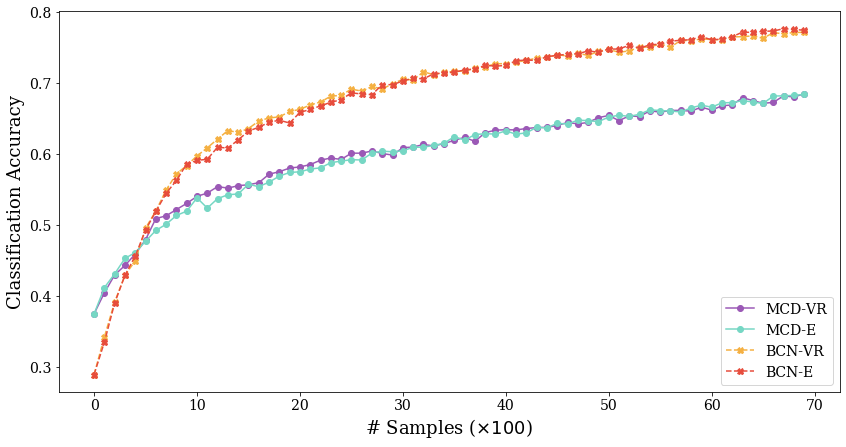

In [19]:
# 1000 initial samples
pth_1 = '../results_archive/McDropout/alexnet_cifar10_isample1000_e50_r70_ac1_optim-SGD_top-k250_b32_rtAfter70_variation-ratio/'
pth_2 = '../results_archive/McDropout/alexnet_cifar10_isample1000_e50_r70_ac1_optim-SGD_top-k250_b32_rtAfter70_entropy/'
pth_3 = '../results_archive/Alexnet_cifar10_isample1000_e40_r70_ac1_Klreg-standard2_b100_mcmc1_netType-jeffreyoptim-SGD_variation-ratio_rtAfter70/'
pth_4 = '../results_archive/Alexnet_cifar10_isample1000_e40_r70_ac1_Klreg-standard2_b100_mcmc1_netType-jeffreyoptim-SGD_entropy_rtAfter70/'
locs = [pth_1, pth_2, pth_3, pth_4]
labels = ['MCD-VR','MCD-E','BCN-VR','BCN-E']
f_name = 'fig_tmp3'
PlotGraph(f_name,locs,labels,truncate_end=70)

2020-05-16 23:27:17 
<p> Updated the results for AL-VR and AL-E. The following changes were made:
What I notices is that when the following transforms are made to the data (along with normalization), the <font color="red"> results of Bayesian and McDropout becomes similar </font>.
<li>  transforms.RandomCrop(32, padding=4) </li>

<li> transforms.RandomHorizontalFlip() </li>

However, if we simply use the <b> transforms.Normalize$((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))$ </b> then Bayesian clearly outperforms McDropout. This needs further investigation. Given that a model should be able to handle a raw form of data without any major modification, I feel the bayesian has the edge and the to-be reported results in our paper will be based on a simple normalization. However, for larger NN such as VGG, it seems without the additional transforms (i.e., random crop and horizontal flip) both Bayesian and McDropout cannot reach the desired accuracy (but Bayesian does out perform McDropout without the additional transforms).

<font color="green">Personal Notes</font>
Besides above changes, the following change was made, but this is mostly for my personal notes.
During ensemble, we remove the dropout and do just 1 or 2 ensemble. Applying dropout during testing was leadin got some bizarre increase in accuracies. For instance, after each round the reported non-ensemble accuracy was 75, but during the final testing the ensemble accuracy was 85 (about 10% increase) and this is definitely not right. So, I modified old technique by removing dropouts during ensemble testing.
</p>

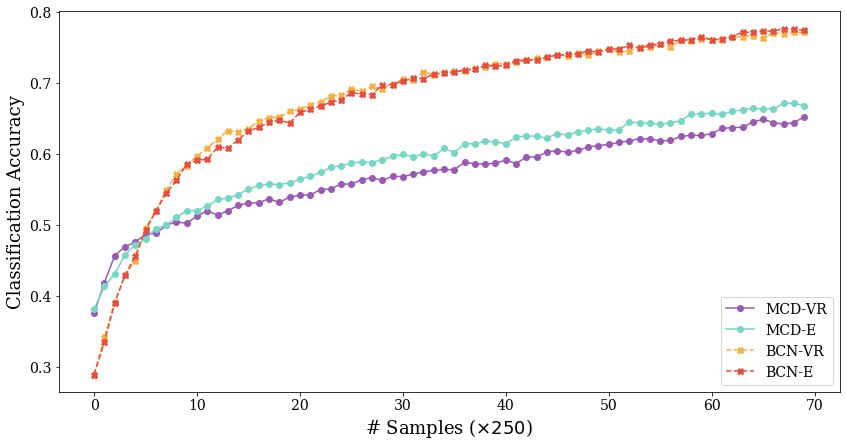

In [20]:
# 1000 initial samples - with SGD
pth_1 = '../results_archive/McDropout/alexnet_cifar10_isample1000_e50_r71_ac1_optim-SGD_top-k250_b32_rtAfter100_variation-ratio/'
pth_2 = '../results_archive/McDropout/alexnet_cifar10_isample1000_e50_r71_ac1_optim-SGD_top-k250_b32_rtAfter100_entropy/'
pth_3 = '../results_archive/Alexnet_cifar10_isample1000_e40_r70_ac1_Klreg-standard2_b100_mcmc1_netType-jeffreyoptim-SGD_variation-ratio_rtAfter70/'
pth_4 = '../results_archive/Alexnet_cifar10_isample1000_e40_r70_ac1_Klreg-standard2_b100_mcmc1_netType-jeffreyoptim-SGD_entropy_rtAfter70/'
locs = [pth_1, pth_2, pth_3, pth_4]
labels = ['MCD-VR','MCD-E','BCN-VR','BCN-E']
f_name = 'fig_k'
PlotGraph(f_name,locs,labels,truncate_end=70, isample=250)

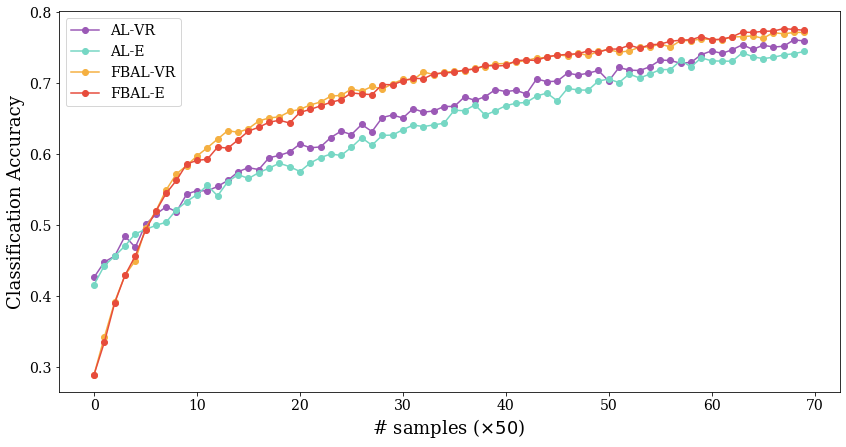

In [4]:
# 1000 initial samples - Using Adam for McDropout and applying all 3 transforms. For bayesian, it is still the old result
pth_1 = '../results_archive/McDropout/alexnet_cifar10_isample1000_e50_r71_ac1_optim-Adam_top-k250_b32_rtAfter100_variation-ratio/'
pth_2 = '../results_archive/McDropout/alexnet_cifar10_isample1000_e50_r71_ac1_optim-Adam_top-k250_b32_rtAfter100_entropy/'
pth_3 = '../results_archive/Alexnet_cifar10_isample1000_e40_r70_ac1_Klreg-standard2_b100_mcmc1_netType-jeffreyoptim-SGD_variation-ratio_rtAfter70/'
pth_4 = '../results_archive/Alexnet_cifar10_isample1000_e40_r70_ac1_Klreg-standard2_b100_mcmc1_netType-jeffreyoptim-SGD_entropy_rtAfter70/'
locs = [pth_1, pth_2, pth_3, pth_4]
labels = ['AL-VR','AL-E','FBAL-VR','FBAL-E']
f_name = 'fig_tmp3'
PlotGraph(f_name,locs,labels,truncate_end=70)

2020-05-05 21:07:20 
<h2 align="center"> VGG16 Using Fully Bayesian NN </h2>

Using SGD optimizer.

2020-05-17 10:16:57 - Using Adam for both bayesian and McDropout, this seems to be the best optimizer

Note: for bayesian, do not use Ams grad since this reduces the performance of the model. One problem with this approach is that after some K rounds (in cifar10 VGG case it is around round 60) the optimizer suddenly jumps to some ill-defined region. In such case, you can retrain the model resuming from a round that was stable and decrease the Learning rate.

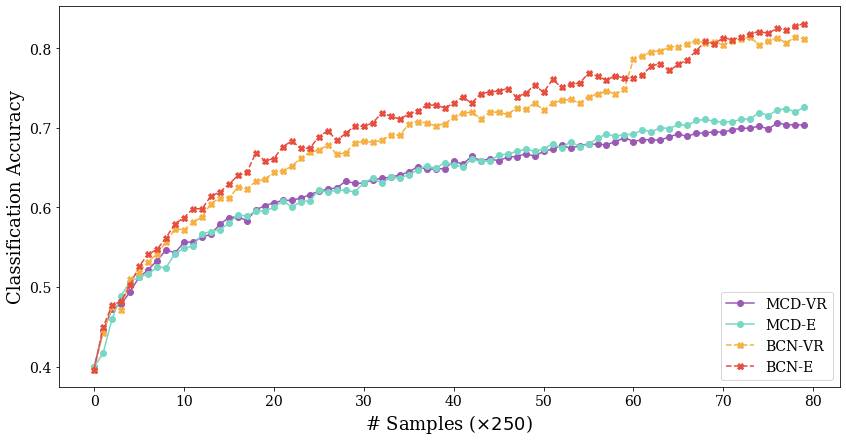

In [21]:
# 2020-05-30 11:22:40 
pth_1 = '../results_archive/McDropout/VGG_cifar10_isample1000_e50_r81_ac1_optim-Adam_top-k250_b100_rtAfter100_variation-ratio_no_augument/'
pth_2 = '../results_archive/McDropout/VGG_cifar10_isample1000_e50_r81_ac1_optim-Adam_top-k250_b100_rtAfter100_entropy_no_augument/'
pth_3 = '../results_archive/VGG_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b100_topK-250_mcmc1_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0_no_augument/'
pth_4 = '../results_archive/VGG_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b100_topK-250_mcmc1_netType-jeffreyoptim-Adam_entropy_rtAfter0_no_augument/'
locs = [pth_1, pth_2, pth_3, pth_4]
labels = ['MCD-VR','MCD-E','BCN-VR','BCN-E']
f_name = 'fig_L'
PlotGraph(f_name,locs,labels,truncate_end=80,isample=250)

2020-05-30 11:39:57 
<p> In a different experiment, I used the selected data points without augmentation (i.e., from the previous graph), but now augmentation them for every round and trained the mode. Note: in this case, we donot perform any active learning, we simply use the data points that was already selected by AL over K rounds using the non-augumented dataset. The only difference here is that we augment and train. In this case, the results are significantly different. With MCD clearly outperforming BNN. That being said, <b> I am not sure about the  validity of this experimental setup </b>. It is obvious that both BNN and MCD benefit from augmentation, but for some reason MCD gets a significant boost.</p>

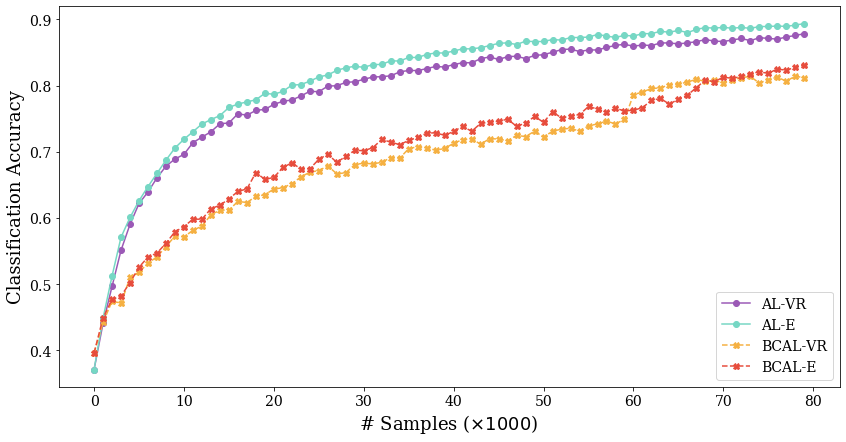

In [48]:
# 2020-05-30 11:22:40 
pth_1 = '../results_archive/McDropout/VGG_cifar10_isample1000_e50_r81_ac1_optim-Adam_top-k250_b100_rtAfter100_variation-ratio_with_augument/'
pth_2 = '../results_archive/McDropout/VGG_cifar10_isample1000_e50_r81_ac1_optim-Adam_top-k250_b100_rtAfter100_entropy_with_augument/'
pth_3 = '../results_archive/VGG_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b100_topK-250_mcmc1_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0_with_augument/'
pth_4 = '../results_archive/VGG_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b100_topK-250_mcmc1_netType-jeffreyoptim-Adam_entropy_rtAfter0_with_augument/'
locs = [pth_1, pth_2, pth_3, pth_4]
labels = ['AL-VR','AL-E','BCAL-VR','BCAL-E']
f_name = 'fig_k'
PlotGraph(f_name,locs,labels,truncate_end=80,isample=1000)

<p> In the following experiment, I used the augumented dataset during the active learning process. In this case, the results of BNN and MCD are exactly same. <b> This is extremely confounding </b>.</p>

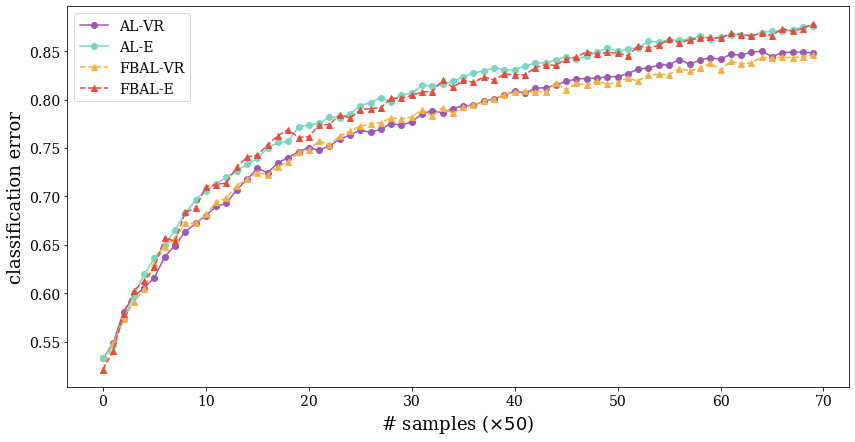

In [26]:
# 2020-05-14 11:02:59  1000 initial samples this is with lr= 0.001 - with Aam
pth_1 = '../results_archive/McDropout/VGG_cifar10_isample1000_e50_r71_ac1_optim-Adam_top-k250_b100_rtAfter100_variation-ratio/'
pth_2 = '../results_archive/McDropout/VGG_cifar10_isample1000_e50_r71_ac1_optim-Adam_top-k250_b100_rtAfter100_entropy/'
pth_3 = '../results_archive/VGG_cifar10_isample1000_e50_r71_ac1_Klreg-standard2_b100_topK-250_mcmc1_netType-jeffreyoptim-Adam_variation-ratio_rtAfter100/'
pth_4 = '../results_archive/VGG_cifar10_isample1000_e50_r71_ac1_Klreg-standard2_b100_topK-250_mcmc1_netType-jeffreyoptim-Adam_entropy_rtAfter100/'
locs = [pth_1, pth_2, pth_3, pth_4]
labels = ['AL-VR','AL-E','FBAL-VR','FBAL-E']
f_name = 'fig_f'
PlotGraph(f_name,locs,labels,truncate_end=70)

<b>2020-08-21 09:11:10</b>
<h3 align="center"> Regression Plots</h3>
<font size="3" color="blue"><b> Global Setting </b></font>
<li>Model: Lenet300-100 </li>
<li>Dataset: <b> Boston  Housing </b>. This dataset 506 data points out of which we use 354 for training (70%) and the rest 152 for testing. It has 13 features. The details about this dataset can be found <a href="https://scikit-learn.org/stable/datasets/index.html#boston-dataset"> here</a></li>
<li> <b>Seed sample</b>: 50</li>
<li> <b>Acquisition Size</b>: After each round 5 new samples are added to the training set</li>
<li><b>Uncertainty Measurement</b>: we just use <b> variance </b> as the measurement of uncertainty. For classification we used variation-ratio and entropy. For regression <font color="red">what are the other measurements of uncertainty?</font></li>
<font size="3" color="blue"><b> Exprimental Setting for Bayesian NN (BCN) </b></font>
    <li><b>Batch size</b>: 8</li>
    <li><b>KL scaling factor: </b>$\frac{1}{\#SamplesPerRound}$. This is according to [3]</li>
    <li><b>Retraining Methodology:</b> Unlike the CVPR paper, <b>we do not retrain from scratch</b>. We found that this method is mostly <b>detrimental to the performance </b> of all models (Both Bayesian and Non-bayesian). At each round, we simply re-use the previous weights, and train the model for a significantly less number of epoch. More precisely, We allot 10% of the training data as validation set and use an early stopping technique, to get the best parameters based on this validation set.</li>
    <li><b>Number of MCMC samples</b>: 1 <b>Note:</b>Since we have a closed form solution, we don't do MCMC to approximate KL. This significantly speeds up the execution time.</li>
    <li><b>Optimization Algorithm</b>: Adam</li>
    <li><b>Number of NN instantiations</b>: 500. That is, when performing active learning, we create 500 instantiations and estimate variation-ratio and entropy.</li>

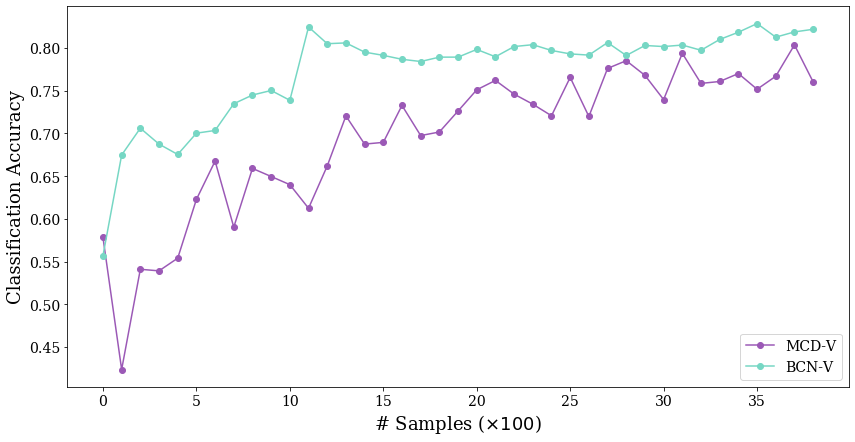

In [23]:
# 2020-05-14 11:02:59  1000 initial samples this is with lr= 0.001 - with Aam
pth_1 = '../results/McDropout/lenet300-100_boston_housing_isample50_e50_activInstances500_r40_ac1_optim-Adam_top-k5_b100_rtAfter100_variation-ratio/'
pth_2 = '../results/Blenet300-100_boston_housing_isample50_e50_r40_ac1_Klreg-standard2_b8_topK-5_mcmc1_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
locs = [pth_1, pth_2]
labels = ['MCD-V','BCN-V']
f_name = 'fig_ab'
PlotGraph(f_name,locs,labels,metric='r2')